In [41]:
import os
import re
import gensim
import pickle
import argparse
from gensim import corpora,models
from data import *
from multiprocessing import cpu_count

In [130]:
'''
parser = argparse.ArgumentParser('Help to build the BOW file')
parser.add_argument('--taskname',type=str,default='sohu100k',help='Taskname e.g sohu100k')
parser.add_argument('--no_below',type=int,default=10,help='The lower bound of count for words to keep, e.g 10')
parser.add_argument('--no_above',type=float,default=0.3,help='The ratio of upper bound of count for words to keep, e.g 0.3')
args = parser.parse_args()

taskname = args.taskname
no_below = args.no_below
no_above = args.no_above
doc_path = os.path.join('data',taskname,'{}_clean_cut_lines.txt'.format(taskname))
bow_path = os.path.join('data',taskname,'{}_bows.pkl'.format(taskname))
voc_path = os.path.join('data',taskname,'{}_vocab.pkl'.format(taskname))
stopwords = os.path.join('data','stopwords.txt')
'''

taskname = 'weibo'
no_below = 15
no_above = 0.3
num_epochs = 20
n_topic = 10
n_cpu = cpu_count()-2
bkpt_continue = args.bkpt_continue
use_tfidf = False
doc_path = os.path.join('data',taskname,'{}_clean_cut_lines.txt'.format(taskname))
bow_path = os.path.join('data',taskname,'{}_bows.pkl'.format(taskname))
voc_path = os.path.join('data',taskname,'{}_vocab.pkl'.format(taskname))
stopwords = os.path.join('data','stopwords.txt')

bows,vocab,txtDocs = build_bow(doc_path,bow_path,voc_path,stopwords,no_below,no_above,False)

NameError: name 'args' is not defined

In [47]:
model_name = 'LDA'
msg = 'cnt'
run_name= '{}_K{}_{}_{}'.format(model_name,n_topic)

In [ ]:
if bkpt_continue:
    lda_model = models.ldamodel.LdaModel.load('ckpt/{}.model'.format(run_name))
    logger = open('logs/{}.log'.format(run_name),'a',encoding='utf-8')
else:
    logger = open('logs/{}.log'.format(run_name),'w',encoding='utf-8')

In [131]:
print('Start Training ...')
use_tfidf = False

if use_tfidf:
    tfidf = models.TfidfModel(bows)
    corpus_tfidf = tfidf[bows]
    lda_model = gensim.models.LdaMulticore(corpus_tfidf,num_topics=n_topic,id2word=vocab.id2token,passes=num_epochs,workers=n_cpu,minimum_probability=0.0)
else:
    lda_model = gensim.models.LdaMulticore(bows,num_topics=n_topic,id2word=vocab.id2token,passes=num_epochs,workers=n_cpu,minimum_probability=0.0)

lda_model.save('ckpt/{}.model'.format(run_name))

Start Training ...


NameError: name 'run_name' is not defined

In [76]:
def show_topics(model=lda_model,topn=-1):
    topic_text = [topic.split(':')[-1].split('+') for idx,topic in model.print_topics(topn)]
    topic_text = [[re.sub(r'"',r'',text.split('*')[-1]).strip() for text in topic] for topic in topic_text]
    return topic_text

In [80]:
topics_text=show_topics()


# Evaluate the Model with Topic Coherence
from gensim.models import CoherenceModel

# Computing the C_V score
cv_coherence_model = CoherenceModel(topics=topics_text,texts=txtDocs,dictionary=vocab,coherence='c_v')
cv_coherence_score = cv_coherence_model.get_coherence_per_topic()
cv_coherence_avg = cv_coherence_model.get_coherence()

# Computing Topic Diversity score
topic_diversity = calc_topic_diversity(topics_text)

# Computing the C_W2V score
try:
    if os.path.exists('data/{}/{}_embeddings.txt'.format(taskname,taskname)):
        keyed_vectors = gensim.models.KeyedVectors.load_word2vec_format('data/{}/{}_embeddings.txt'.format(taskname,taskname),binary=False)
        w2v_coherence_model = CoherenceModel(topics=topics_text,texts=txtDocs,dictionary=vocab,coherence='c_w2v',keyed_vectors=keyed_vectors)
    else:
        w2v_coherence_model = CoherenceModel(topics=topics_text,texts=txtDocs,dictionary=vocab,coherence='c_w2v')
    w2v_coherence_score = w2v_coherence_model.get_coherence_per_topic()
    w2v_coherence_avg = w2v_coherence_model.get_coherence()
except:
    #In case of OOV Error
    w2v_coherence_score = cv_coherence_score
    w2v_coherence_avg = cv_coherence_avg

# Computing the C_UCI score
c_uci_coherence_model = CoherenceModel(topics=topics_text,texts=txtDocs,dictionary=vocab,coherence='c_uci')
c_uci_coherence_score = c_uci_coherence_model.get_coherence_per_topic()
c_uci_coherence_avg = c_uci_coherence_model.get_coherence()

# Computing the C_NPMI score
c_npmi_coherence_model = CoherenceModel(topics=topics_text,texts=txtDocs,dictionary=vocab,coherence='c_npmi')
c_npmi_coherence_score = c_npmi_coherence_model.get_coherence_per_topic()
c_npmi_coherence_avg = c_npmi_coherence_model.get_coherence()


logger.write('Topics:\n')

for tp,cv,w2v in zip(topics_text,cv_coherence_score,w2v_coherence_score):
    print('{}+++$+++cv:{}+++$+++w2v:{}'.format(tp,cv,w2v))
    logger.write('{}+++$+++cv:{}+++$+++w2v:{}\n'.format(str(tp),cv,w2v))

print('c_v for ${}$: {}'.format(run_name,cv_coherence_avg))
logger.write('c_v for ${}$: {}\n'.format(run_name, cv_coherence_avg))

print('c_w2v for ${}$: {}'.format(run_name,w2v_coherence_avg))
logger.write('c_w2v for ${}$: {}\n'.format(run_name, w2v_coherence_avg))

print('c_uci for ${}$: {}'.format(run_name,c_uci_coherence_avg))
logger.write('c_uci for ${}$: {}\n'.format(run_name, c_uci_coherence_avg))

print('c_npmi for ${}$: {}'.format(run_name,c_npmi_coherence_avg))
logger.write('c_npmi for ${}$: {}\n'.format(run_name, c_npmi_coherence_avg))

print('t_div for ${}$: {}'.format(run_name,topic_diversity))
logger.write('t_div for ${}$: {}\n'.format(run_name, topic_diversity))


logger.close()
exit(0)

import os
import re
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torch.utils.data import Dataset,DataLoader
import numpy as np
import matplotlib.pyplot as plt
import argparse
import gensim
from sklearn.metrics.cluster import normalized_mutual_info_score
from data import *
from utils import *
from vae import VAE

parser = argparse.ArgumentParser(description='Neural Topic Model')

# 添加参数步骤
parser.add_argument('--taskname', type=str,default='sub',help='Name of the task e.g subX')
parser.add_argument('--n_topic', type=int,default=20,help='Number of the topics')
parser.add_argument('--num_epochs',type=int,default=2,help='Num of epochs')
parser.add_argument('--batch_size',type=int,default=512,help='Batch Size')
parser.add_argument('--gpu',type=str,default='0',help='GPU device e.g 1')
parser.add_argument('--ratio',type=float,default=1.0,help='Ratio of the train data for actual use')
parser.add_argum

In [64]:
import pyLDAvis.gensim
import pickle 
import pyLDAvis
# Visualize the topics
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model, bows, vocab)
LDAvis_prepared

/work0/zhangleilan/anaconda3/envs/py36/lib/python3.6/site-packages/pyLDAvis/_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
2      0.143677  0.120693       1        1  12.247437
4      0.164937 -0.145926       2        1  12.009990
5     -0.004100  0.174533       3        1  11.178312
8     -0.060393  0.039750       4        1  11.159439
0     -0.151349  0.119396       5        1  11.123916
3     -0.157269 -0.090375       6        1   9.181974
9      0.197132 -0.066333       7        1   8.874026
1      0.109215  0.028360       8        1   8.179304
6     -0.132863 -0.169696       9        1   8.026977
7     -0.108987 -0.010403      10        1   8.018636, topic_info=     Category         Freq Term        Total  loglift  logprob
term                                                          
1226  Default  7746.000000    岁  7746.000000  30.0000  30.0000
38    Default  5217.000000    元  5217.000000  29.0000  29.0000
256   Default  3239.000000   警方  3239.000000  28.0000  28.0000
116   Default  3878.000000   孩子  3878.000000  27.0000  27.0000
2954  Default  3309.000000   男子  3309.000000  26.0000  26.0000
337   Default  4395.000000   中国  4395.000000  25.0000  25.0000
434   Default  2760.000000   学生  2760.000000  24.0000  24.0000
1854  Default  1349.000000   医生  1349.000000  23.0000  23.0000
1581  Default  2156.000000   医院  2156.000000  22.0000  22.0000
1970  Default  1079.000000   地铁  1079.000000  21.0000  21.0000
1291  Default  1979.000000    吃  1979.000000  20.0000  20.0000
1632  Default  1005.000000    线  1005.000000  19.0000  19.0000
2245  Default  1453.000000   司机  1453.000000  18.0000  18.0000
1634  Default  1859.000000    号  1859.000000  17.0000  17.0000
406   Default  1824.000000    辆  1824.000000  16.0000  16.0000
1418  Default  1272.000000    路  1272.000000  15.0000  15.0000
775   Default  1979.000000   死亡  1979.000000  14.0000  14.0000
1151  Default   853.000000   高速   853.000000  13.0000  13.0000
1099  Default  1387.000000   民警  1387.000000  12.0000  12.0000
983   Default  1873.000000   老人  1873.000000  11.0000  11.0000
1222  Default  1485.000000   儿子  1485.000000  10.0000  10.0000
1424  Default  1159.000000    站  1159.000000   9.0000   9.0000
186   Default  3175.000000   发生  3175.000000   8.0000   8.0000
234   Default  1266.000000   老师  1266.000000   7.0000   7.0000
2708  Default  1788.000000   美国  1788.000000   6.0000   6.0000
741   Default  2365.000000   万元  2365.000000   5.0000   5.0000
23    Default  5957.000000    说  5957.000000   4.0000   4.0000
928   Default  1725.000000   女子  1725.000000   3.0000   3.0000
959   Default  1955.000000   手机  1955.000000   2.0000   2.0000
1079  Default  1356.000000   女儿  1356.000000   1.0000   1.0000
...       ...          ...  ...          ...      ...      ...
280   Topic10   136.956345   蔬菜   166.648483   2.3272  -6.6648
5983  Topic10   242.200058   电梯   357.158173   2.1350  -6.0947
2733  Topic10   140.701035   航空   173.259888   2.3152  -6.6378
2707  Topic10   218.418106   奶粉   315.991699   2.1541  -6.1980
2240  Topic10   269.280792   城管   434.760498   2.0444  -5.9887
622   Topic10   283.766083   垃圾   487.223999   1.9828  -5.9363
2386  Topic10   259.551697   高铁   474.128662   1.9209  -6.0255
3254  Topic10   257.405609   销售   479.131531   1.9021  -6.0338
1556  Topic10   271.892212   飞机   530.588135   1.8548  -5.9790
5461  Topic10   196.260223   食用   304.743622   2.0834  -6.3050
144   Topic10   274.613312   旅客   549.476257   1.8298  -5.9691
5470  Topic10   186.771652    肉   289.543945   2.0850  -6.3546
3484  Topic10   269.333008    水   598.510193   1.7249  -5.9885
1102  Topic10   410.141876   专家  1529.575195   1.2072  -5.5680
716   Topic10   630.464111   广州  3918.510986   0.6964  -5.1380
330   Topic10   624.559937   发现  4224.542480   0.6118  -5.1474
138   Topic10   475.689026   小时  2472.175049   0.8753  -5.4197
286   Topic10   276.993530   市场   794.093994   1.4702  -5.9605
209   Topic10   610.391602    称  6759.443359   0.1188  -5.1704
543   Topic10   236.518112    倍  

In [65]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim.prepare(lda_model_tfidf, bows, vocab)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0      0.108234 -0.120065       1        1  29.109871
7     -0.138483  0.102773       2        1  14.767003
8     -0.044065 -0.098805       3        1   9.516067
9     -0.036950  0.101021       4        1   9.165974
2     -0.070317  0.042368       5        1   8.977812
5     -0.089262 -0.092366       6        1   8.653444
4      0.216978  0.104560       7        1   8.119336
1      0.051280  0.069462       8        1   4.225569
3     -0.094007 -0.029459       9        1   3.899813
6      0.096592 -0.079489      10        1   3.565113, topic_info=      Category         Freq Term        Total  loglift  logprob
term                                                           
38     Default  2358.000000    元  2358.000000  30.0000  30.0000
41     Default  1030.000000   事故  1030.000000  29.0000  29.0000
406    Default  1186.000000    辆  1186.000000  28.0000  28.0000
2335   Default   659.000000   银行   659.000000  27.0000  27.0000
186    Default  1701.000000   发生  1701.000000  26.0000  26.0000
775    Default  1272.000000   死亡  1272.000000  25.0000  25.0000
434    Default  1597.000000   学生  1597.000000  24.0000  24.0000
2245   Default  1021.000000   司机  1021.000000  23.0000  23.0000
1970   Default   712.000000   地铁   712.000000  22.0000  22.0000
2954   Default  1832.000000   男子  1832.000000  21.0000  21.0000
337    Default  2129.000000   中国  2129.000000  20.0000  20.0000
1264   Default   785.000000   受伤   785.000000  19.0000  19.0000
1111   Default   541.000000   考生   541.000000  18.0000  18.0000
188    Default  1130.000000   现场  1130.000000  17.0000  17.0000
234    Default   910.000000   老师   910.000000  16.0000  16.0000
256    Default  1669.000000   警方  1669.000000  15.0000  15.0000
1548   Default   701.000000   乘客   701.000000  14.0000  14.0000
1124   Default   496.000000   考试   496.000000  13.0000  13.0000
1904   Default   986.000000    车   986.000000  12.0000  12.0000
3288   Default   537.000000   气温   537.000000  11.0000  11.0000
428    Default   536.000000   高考   536.000000  10.0000  10.0000
1556   Default   429.000000   飞机   429.000000   9.0000   9.0000
1634   Default  1044.000000    号  1044.000000   8.0000   8.0000
404    Default   728.000000   交警   728.000000   7.0000   7.0000
795    Default  1788.000000   网友  1788.000000   6.0000   6.0000
1632   Default   647.000000    线   647.000000   5.0000   5.0000
2274   Default   416.000000   比赛   416.000000   4.0000   4.0000
959    Default  1213.000000   手机  1213.000000   3.0000   3.0000
928    Default  1134.000000   女子  1134.000000   2.0000   2.0000
1226   Default  2872.000000    岁  2872.000000   1.0000   1.0000
...        ...          ...  ...          ...      ...      ...
5064   Topic10   102.171097   车厢   193.110779   2.6974  -6.1473
13362  Topic10    34.605053   嫦娥    45.543251   3.0593  -7.2300
1970   Topic10   215.794342   地铁   712.456482   2.1396  -5.3997
1548   Topic10   201.599228   乘客   701.807251   2.0866  -5.4677
836    Topic10   147.483612  公交车   469.113770   2.1768  -5.7803
9120   Topic10    38.201614  关键词    54.275551   2.9828  -7.1311
5884   Topic10    94.487030   婚礼   299.548096   2.1802  -6.2255
6211   Topic10    67.416435   车门   174.158478   2.3849  -6.5631
7926   Topic10    66.595604   座位   190.966202   2.2805  -6.5753
304    Topic10    50.154652  羽绒服   100.366539   2.6403  -6.8589
795    Topic10   171.948914   网友  1788.022217   0.9923  -5.6268
5653   Topic10    80.318314    拍   328.046600   1.9268  -6.3880
3637   Topic10    71.885910   下车   252.179214   2.0789  -6.4989
1424   Topic10   102.617256    站   736.235413   1.3634  -6.1430
2083   Topic10    94.113152   视频   584.741272   1.5073  -6.2295
140    Topic10    78.036896   列车   387.501862   1.7314  -6.4168
2245   Topic10   108.420815   司机  1021.179626   1.0913  -6.0880
1632   Topic10    86.985489    线   647.874817   1.3260  -6.3082
11772  Topic10    51.196251    蛇   122.240311

In [89]:
def show_topics(model=lda_model,topn=20,n_topic=10,fix_topic=None,showWght=False):
    global vocab
    topics = []
    def show_one_tp(tp_idx):
        if showWght:
            return [(vocab.id2token[t[0]],t[1]) for t in lda_model.get_topic_terms(tp_idx)]
        else:
            return [vocab.id2token[t[0]] for t in lda_model.get_topic_terms(tp_idx)]
    if fix_topic is None:
        for i in range(n_topic):
            topics.append(show_one_tp(i))
    else:
        topics.append(show_one_tp(fix_topic))
    return topics

In [93]:
show_topics(lda_model)

[['广州', '中国', '日本', '分', '天气', '级', '考生', '气温', '高考', '全国'],
 ['医生', '医院', '称', '岁', '手机', '吃', '发现', '患者', '近日', '说'],
 ['岁', '说', '孩子', '儿子', '老人', '女儿', '做', '父母', '妻子', '妈妈'],
 ['元', '价格', '点', '号', '记者', '广州', '称', '票', '分', '现场'],
 ['男子', '发生', '称', '岁', '警方', '点', '发现', '死亡', '现场', '辆'],
 ['中国', '学生', '说', '美国', '老师', '网友', '学校', '称', '近日', '位'],
 ['地铁', '线', '号', '路', '站', '高速', '司机', '公里', '条', '广州'],
 ['吃', '广州', '发现', '称', '产品', '小时', '食品', '航班', '专家', '近日'],
 ['万元', '称', '银行', '元', '信息', '近日', '法院', '手机', '公司', '企业'],
 ['警方', '孩子', '岁', '男子', '称', '发现', '近日', '女子', '民警', '发生']]

In [96]:
mat = lda_model.get_topics()

In [97]:
mat.shape

(10, 15513)

In [105]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

tsne = TSNE(n_components=2)
pca = PCA(n_components=2)

In [108]:
reduced_tsne = tsne.fit_transform(mat)

In [106]:
reduced_pca = pca.fit_transform(mat)

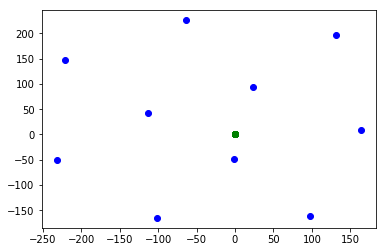

In [109]:
import matplotlib.pyplot as plt

plt.scatter(reduced_tsne[:,0],reduced_tsne[:,1],c='b')
plt.scatter(reduced_pca[:,0],reduced_pca[:,1],c='g')
plt.show()

In [111]:
reduced_pca

array([[-0.01213688, -0.01003719],
       [ 0.00610551, -0.00422352],
       [ 0.019177  , -0.0069379 ],
       [-0.01414894,  0.0035188 ],
       [ 0.01333287,  0.01453257],
       [-0.0025898 , -0.01843209],
       [-0.01882578,  0.0211214 ],
       [-0.00846186, -0.00273252],
       [-0.00567943, -0.00504051],
       [ 0.02322729,  0.00823098]], dtype=float32)

In [125]:
lda_model.inference([bows[3],bows[5]])[0]

array([[ 0.10000402,  0.10002188, 10.825656  ,  0.10002134,  0.10000862,
         0.10002498,  0.10000876,  0.10002911, 14.332465  ,  0.10001729],
       [ 2.5263438 ,  0.10000515,  0.1000156 ,  0.10000812,  0.10000315,
        15.128706  ,  2.6226563 ,  0.10000495,  0.10000653,  0.1000196 ]],
      dtype=float32)

In [128]:
lda_model[bows[3]]

0.969176

In [127]:
sorted(lda_model[bows[10]], key=lambda tup: -1*tup[1])

[(5, 0.8885484), (7, 0.07137809)]